In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['bird-songs-generate-spectrograms', 'multilabel-bird-species-classification-nips2013']


In [2]:
! tar xf ../input/bird-songs-generate-spectrograms/spectrograms.tar.bz2

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import matplotlib.pyplot as plt

In [4]:
data_dir = Path('../input')
label_dir = data_dir/'multilabel-bird-species-classification-nips2013/nips4b_bird_challenge_train_labels/NIPS4B_BIRD_CHALLENGE_TRAIN_LABELS'
spect_dir = Path('./spectrograms')
resized_dir = Path('./spectrograms_resized')
resized_dir.mkdir(parents=True, exist_ok=True)

train [max_width, min_width, height]:
[669.0, 136.0, 193.0]


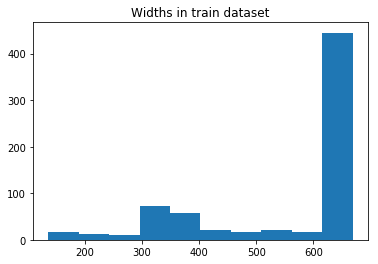

test [max_width, min_width, height]:
[669.0, 134.0, 193.0]


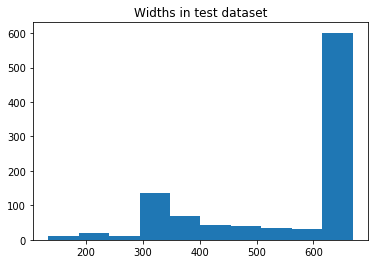

In [5]:
import PIL.Image as pimg
import torch

for ds in ('train', 'test'):
    sizes = torch.Tensor([pimg.open(p).size for p in (spect_dir/ds).glob('*.png')])
    print(ds, "[max_width, min_width, height]:")
    print(list(map(lambda t:t.item(), (torch.max(sizes[:, 0]),
                                       torch.min(sizes[:, 0]),
                                       sizes[0, 1]))))
    plt.hist(sizes[:, 0])
    plt.title(f'Widths in {ds} dataset')
    plt.show()

In [6]:
def pad_repeat(image:pimg.Image, width:int)->pimg.Image:
  if (image.width >= width):
    return image

  new_im = pimg.new('RGB', (width, image.height))
  offset = (width - image.width) // 2 % image.width

  if offset > 0:  # first part
    box = (image.width - offset, 0, image.width, image.height)
    new_im.paste(image.crop(box))

  while offset < width:
    new_im.paste(image, (offset, 0))
    offset += image.width
  return new_im

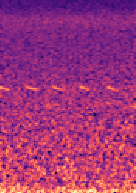

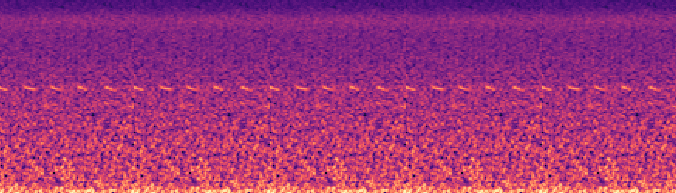

In [10]:
to_pad = pimg.open(str(spect_dir/'train'/'nips4b_birds_trainfile173.png'))
display(to_pad)
padded = pad_repeat(to_pad, 676)
display(padded)

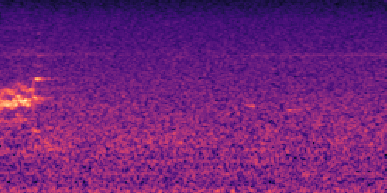

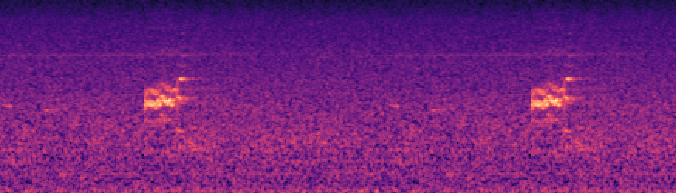

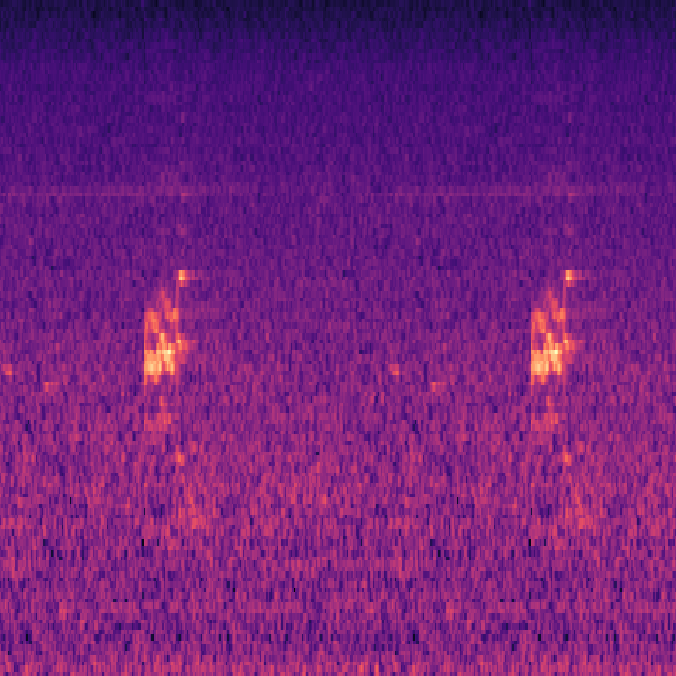

In [9]:
to_pad = pimg.open(str(spect_dir/'train'/'nips4b_birds_trainfile074.png'))
display(to_pad)
padded = pad_repeat(to_pad, 676)
display(padded)
display(padded.resize((676, 676)))

In [ ]:
from fastprogress import progress_bar

def pad_resize_folder(from_path, to_path, folder=""):
  (to_path/folder).mkdir(parents=True, exist_ok=True)
  fns = list((from_path/folder).glob('*.png'))
  pb = progress_bar(range(len(fns)))
  mw = max(map(lambda p: pimg.open(p).width, fns))
  for i, src in zip(pb, fns):
    dest = to_path/folder/src.name
    pad_repeat(pimg.open(src), mw).resize((mw, mw)).save(dest)
    pb.comment = src.name

In [ ]:
for ds in ('train', 'test'):
    pad_resize_folder(spect_dir, resized_dir, ds)

In [ ]:
import random

for ds in ('train', 'test'):
    fig, axs = plt.subplots(3,3,figsize=(12,12))
    fig.suptitle(ds)
    fns = list((resized_dir/ds).glob('*.png'))
    for fn, ax in zip(random.choices(fns, k=9),
                      axs.flatten()):
        ax.imshow(plt.imread(str(fn)))
        ax.set_title(fn.stem)
        ax.axis('off')


In [ ]:
! tar cjf spectrograms_resized.tar.bz2 $resized_dir
! rm -r $spect_dir $resized_dir